In [250]:
import os
import numpy as np
import pandas as pd
import tempfile

import pandapower as pp
import pandapower.networks as nw
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import pandapower.plotting as pplt
import matplotlib.pyplot as plt
from pandapower.plotting.plotly import pf_res_plotly

#creating our net
net = nw.create_cigre_network_mv()

#Creating buses and trafos

pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14 - 0.63MVA', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11 - 0.4MVA',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')

#print(net)

#ax = pplt.simple_plot(net, show_plot = False)
#clc = pplt.create_line_collection(net, color ="g", linewidth = 3.,use_bus_geodata=(True))
#pplt.draw_collections([clc], ax=ax)
#plt.show()

#Adding CS at rated power (6.6 kW)


max_line_loading=100

max_vm_pu= 1.1

min_vm_pu= 0.9

net.switch.closed[1] = True
net.switch.closed[2] = True
net.switch.closed[4] = True

In [251]:
#importing the active and reactive power of loads from excel
df_active = pd.read_csv('active_power_time_series_ev_load.csv')
df_reactive = pd.read_csv('reactive_power_time_series_ev_load.csv')
# create the data source from
ds_active = DFData(df_active)
ds_reactive = DFData(df_reactive)

def timeseries_example(output_dir):
    
    #defing the time step
    n_timesteps = 24
    
    # 3. create controllers (to control P values of the load) ds_p is for active power and ds_q for reactive power
    create_controllers(net, ds_active, ds_reactive)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps) 
    
    

def create_controllers(net,ds_active,ds_reactive):
    load_index=net.load.index
    load_name=net.load.name
    for i in range(len(load_index)):
        ConstControl(net, element='load', variable='p_mw', element_index=load_index[i],
                 data_source=ds_active, profile_name=load_name[i])
        ConstControl(net, element='load', variable='q_mvar', element_index=load_index[i],
                 data_source=ds_reactive, profile_name=load_name[i])

def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    ow.log_variable('res_trafo','loading_percent')
    return ow

In [252]:
output_dir = os.path.join("time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:00<00:00, 35.79it/s]


In [253]:
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
    
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)

trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

if any(line_loading.max()>100):
        print("Overloaded lines")

elif any(vm_pu.max()>max_vm_pu):
        print("voltage over maximum")

elif any(vm_pu.min()<min_vm_pu):
         print("voltage below minimum")

In [254]:
lowlimit1=44
uplimit1=120

#Bus CS 14 (0.63 MVA) - trafo id: 2

for i in range (1,lowlimit1):
    l = str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

c=lowlimit1
while all(vm_pu.max()<max_vm_pu) and all(line_loading.max()<100) and all(vm_pu.min()>min_vm_pu) and c<uplimit1 and all(trafo_loading.max()<100):
    
    c=c+1
    print(c)
    k=str(c)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+k)
    
    output_dir = os.path.join("time_series_ev")
    print("Results can be found in your local temp folder: {}".format(output_dir))
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    timeseries_example(output_dir)

    ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
    line_loading = pd.read_excel(ll_file, index_col=0)
    
    vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
    vm_pu = pd.read_excel(vm_pu_file, index_col=0)
    
    trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
    trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

    if any(line_loading.max()>100):
        print("Overloaded lines")

    elif any(vm_pu.max()>max_vm_pu):
        print("voltage over maximum")

    elif any(vm_pu.min()<min_vm_pu):
         print("voltage below minimum")
            
    elif c==uplimit1:
        print("no maximum has been found")
        
    elif any(trafo_loading.max()>100):
        print("overloaded trafo")
        
#creating our net
net = nw.create_cigre_network_mv()

net.switch.closed[1] = True
net.switch.closed[2] = True
net.switch.closed[4] = True

#Creating buses and trafos

pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14 - 0.63MVA', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11 - 0.4MVA',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')


for i in range (1,c):
    l = str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

output_dir = os.path.join("time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)

vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)


trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

45
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:01<00:00, 16.30it/s]


46
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:01<00:00, 13.55it/s]


overloaded trafo
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:01<00:00, 16.96it/s]


In [255]:
trafo_loading.max()

0    79.842051
1    81.994175
2    99.663665
3     0.342666
4     0.342644
5     0.324934
6     0.324921
dtype: float64

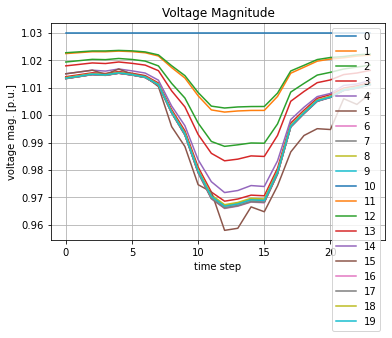

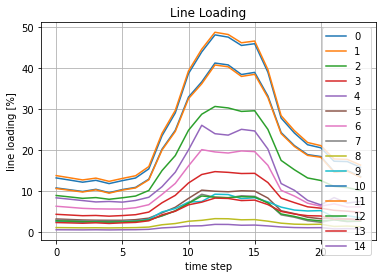

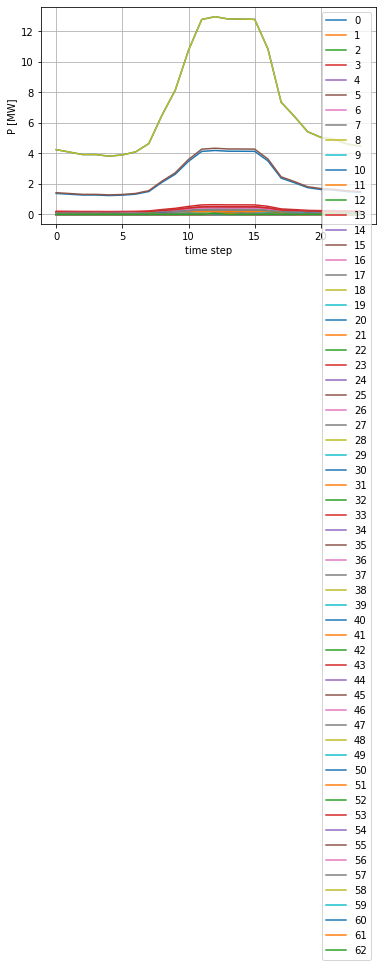

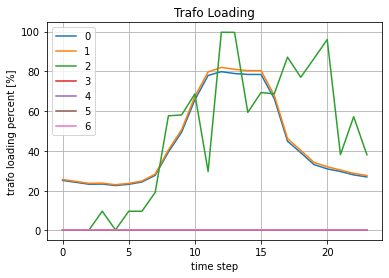

In [256]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

#trafo results
load_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="trafo")
plt.xlabel("time step")
plt.ylabel("trafo loading percent [%]")
plt.title("Trafo Loading")
plt.grid()
plt.show()



In [257]:
c15=c-1
EVs_B15=c15

lowlimit2=c15+23
uplimit2=c15+100

#Bus CS 14 (0.63 MVA) - trafo id: 2

for i in range (c15,lowlimit2):
    l = str(i)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

c=lowlimit2
while all(vm_pu.max()<max_vm_pu) and all(line_loading.max()<100) and all(vm_pu.min()>min_vm_pu) and c<uplimit2 and all(trafo_loading.max()<100):
    
    
    c=c+1
    print(c)
    k=str(c)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+k)
    
    output_dir = os.path.join("time_series_ev")
    print("Results can be found in your local temp folder: {}".format(output_dir))
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    timeseries_example(output_dir)

    ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
    line_loading = pd.read_excel(ll_file, index_col=0)
    
    vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
    vm_pu = pd.read_excel(vm_pu_file, index_col=0)
    
    
    trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
    trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)


    if any(line_loading.max()>100):
        print("Overloaded lines")

    elif any(vm_pu.max()>max_vm_pu):
        print("voltage over maximum")

    elif any(vm_pu.min()<min_vm_pu):
         print("voltage below minimum")
            
    elif c==uplimit2:
        print("no maximum has been found")
   
    elif any(trafo_loading.max()>100):
        print("overloaded trafo")
        
c16=c-1
EVs_B16=c16-c15        
print(EVs_B16)        
        
#creating our net
net = nw.create_cigre_network_mv()
net.switch.closed[1] = True
net.switch.closed[2] = True
net.switch.closed[4] = True

#Creating buses and trafos

pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14 - 0.63MVA', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11 - 0.4MVA',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')


for i in range (1,c15+1):
    l = str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c15+1,c16+1):
    l = str(i)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
output_dir = os.path.join("time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)

vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)

trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

69
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:02<00:00, 10.06it/s]


70
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:03<00:00,  7.34it/s]


overloaded trafo
24
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:02<00:00, 11.92it/s]


In [258]:
trafo_loading.max()

0    80.361129
1    82.519704
2    99.807460
3    94.996708
4     0.342644
5     0.324934
6     0.324921
dtype: float64

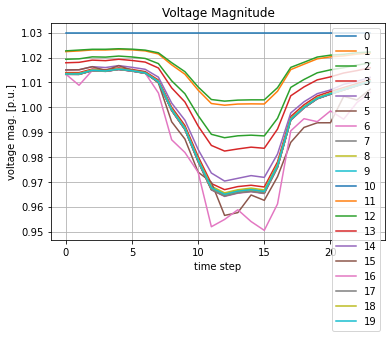

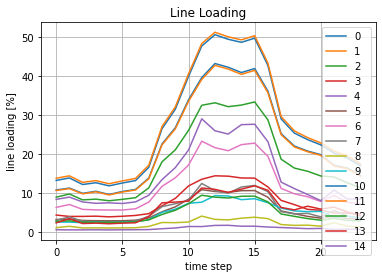

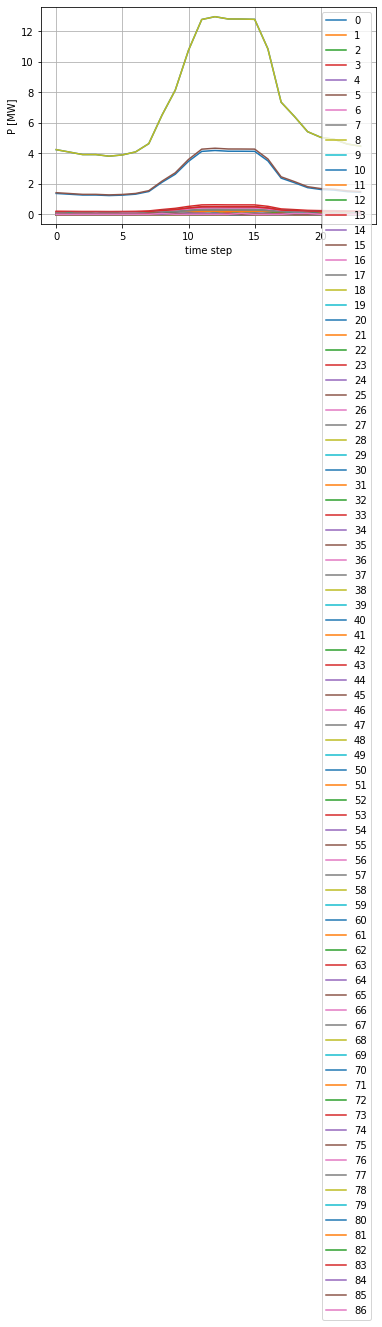

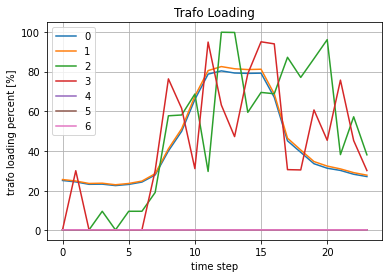

In [259]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

#trafo results
load_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="trafo")
plt.xlabel("time step")
plt.ylabel("trafo loading percent [%]")
plt.title("Trafo Loading")
plt.grid()
plt.show()



In [260]:
lowlimit3=c16+18
uplimit3=c16+70


for i in range (c16,lowlimit3):
    l = str(i)
    pp.create_load(net, bus=17, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

c=lowlimit3
while all(vm_pu.max()<max_vm_pu) and all(line_loading.max()<100) and all(vm_pu.min()>min_vm_pu) and c<uplimit3  and all(trafo_loading.max()<100):
    
    c=c+1
    print(c)
    k=str(c)
    pp.create_load(net, bus=17, p_mw=0.0066, q_mvar=0, name="Vehicle "+k)
    
    output_dir = os.path.join("time_series_ev")
    print("Results can be found in your local temp folder: {}".format(output_dir))
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    timeseries_example(output_dir)

    ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
    line_loading = pd.read_excel(ll_file, index_col=0)
    
    vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
    vm_pu = pd.read_excel(vm_pu_file, index_col=0)
    
    trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
    trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

    if any(line_loading.max()>100):
        print("Overloaded lines")

    elif any(vm_pu.max()>max_vm_pu):
        print("voltage over maximum")

    elif any(vm_pu.min()<min_vm_pu):
         print("voltage below minimum")
            
    elif c==uplimit3:
        print("no maximum has been found")
    elif any(trafo_loading.max()>100):
        print("overloaded trafo")
        
        
c17=c-1
EVs_B17=c17-c16       
print(EVs_B17)        
        
#creating our net
net = nw.create_cigre_network_mv()
net.switch.closed[1] = True
net.switch.closed[2] = True
net.switch.closed[4] = True

#Creating buses and trafos

pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14 - 0.63MVA', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11 - 0.4MVA',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')


for i in range (1,c15+1):
    l = str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c15+1,c16+1):
    l = str(i)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c16+1,c17+1):
    l = str(i)
    pp.create_load(net, bus=17, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
output_dir = os.path.join("time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)

vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)


trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

88
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:03<00:00,  7.54it/s]


89
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:04<00:00,  5.01it/s]


90
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


91
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:09<00:00,  2.63it/s]


overloaded trafo
21
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:02<00:00,  9.23it/s]


In [261]:
trafo_loading.max()

0    81.020922
1    83.181789
2    99.991247
3    95.129642
4    94.024742
5     0.324934
6     0.324921
dtype: float64

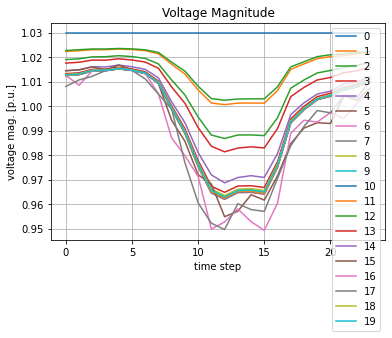

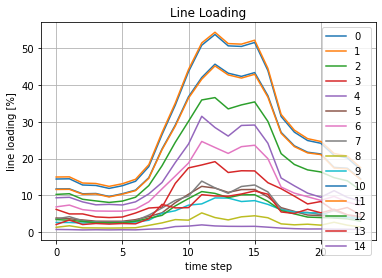

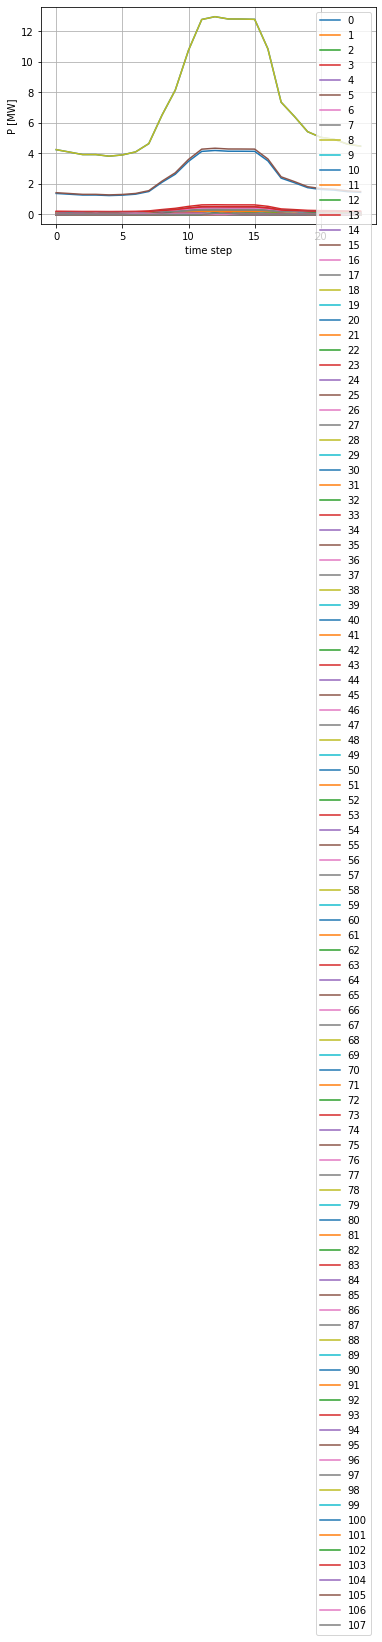

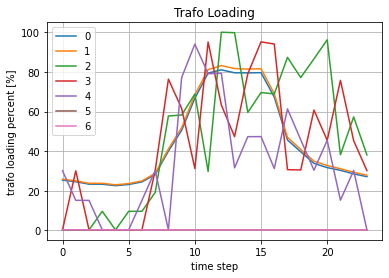

In [262]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

#trafo results
load_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="trafo")
plt.xlabel("time step")
plt.ylabel("trafo loading percent [%]")
plt.title("Trafo Loading")
plt.grid()
plt.show()



In [263]:
lowlimit4=c17+0
uplimit4=c17+60

#Bus CS 14 (0.63 MVA) - trafo id: 2

for i in range (c17,lowlimit4):
    l = str(i)
    pp.create_load(net, bus=18, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
c=lowlimit4
while all(vm_pu.max()<max_vm_pu) and all(vm_pu.min()>min_vm_pu) and all(line_loading.max()<100) and c<uplimit4  and all(trafo_loading.max()<100):
    c=c+1
    print(c)
    k=str(c)
    pp.create_load(net, bus=18, p_mw=0.0066, q_mvar=0, name="Vehicle "+k)
    
    output_dir = os.path.join("time_series_ev")
    print("Results can be found in your local temp folder: {}".format(output_dir))
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    timeseries_example(output_dir)

    ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
    line_loading = pd.read_excel(ll_file, index_col=0)
    
    vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
    vm_pu = pd.read_excel(vm_pu_file, index_col=0)
    
    trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
    trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

    if any(line_loading.max()>100):
        print("Overloaded lines")

    elif any(vm_pu.max()>max_vm_pu):
        print("voltage over maximum")

    elif any(vm_pu.min()<min_vm_pu):
         print("voltage below minimum")
            
    elif c==uplimit4:
        print("no maximum has been found")
        
    elif any(trafo_loading.max()>100):
        print("overloaded trafo")
        
c18=c-1
EVs_B18=c18-c17        
print(EVs_B18)        
        
#creating our net
net = nw.create_cigre_network_mv()
net.switch.closed[1] = True
net.switch.closed[2] = True
net.switch.closed[4] = True

#Creating buses and trafos

pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14 - 0.63MVA', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11 - 0.4MVA',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')


for i in range (1,c15+1):
    l = str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c15+1,c16+1):
    l = str(i)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c16+1,c17+1):
    l = str(i)
    pp.create_load(net, bus=17, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c17+1,c18+1):
    l = str(i)
    pp.create_load(net, bus=18, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
output_dir = os.path.join("time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)

vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)

trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

91
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:03<00:00,  6.92it/s]


92
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:05<00:00,  4.55it/s]


93
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


94
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:09<00:00,  2.52it/s]


95
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


96
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


97
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:16<00:00,  1.50it/s]


98
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


99
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:20<00:00,  1.18it/s]


100
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


101
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:25<00:00,  1.07s/it]


102
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


103
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


104
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


overloaded trafo
13
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


In [264]:
trafo_loading.max()

0    81.020922
1    83.181789
2    99.991247
3    95.173484
4    94.156636
5    75.912417
6     0.324921
dtype: float64

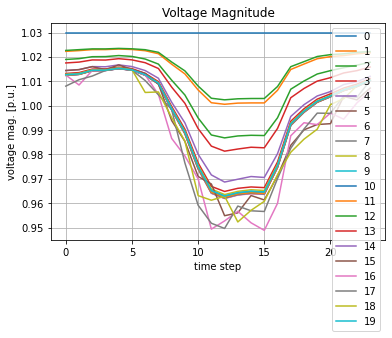

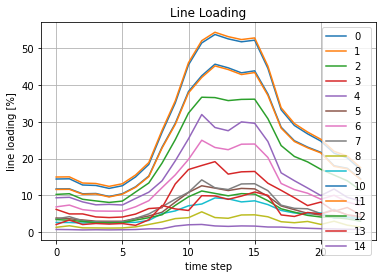

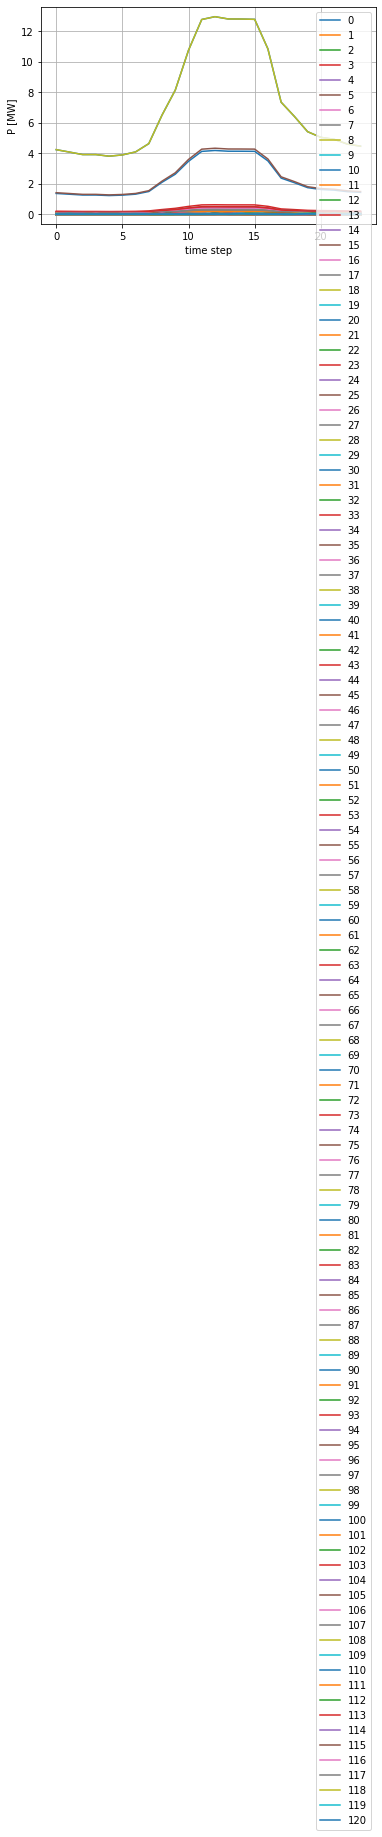

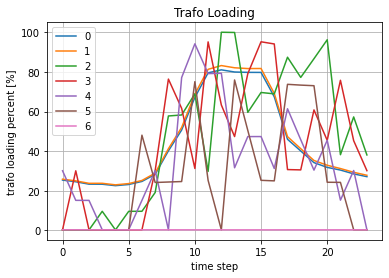

In [265]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

#trafo results
load_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="trafo")
plt.xlabel("time step")
plt.ylabel("trafo loading percent [%]")
plt.title("Trafo Loading")
plt.grid()
plt.show()



In [266]:
lowlimit5=c18+0
uplimit5=c18+40

#Bus CS 14 (0.63 MVA) - trafo id: 2

for i in range (c18,lowlimit5):
    l = str(i)
    pp.create_load(net, bus=19, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

c=lowlimit5
while all(vm_pu.max()<max_vm_pu) and all(vm_pu.min()>min_vm_pu) and all(line_loading.max()<100) and c<uplimit5  and all(trafo_loading.max()<100):
    c=c+1
    print(c)
    k=str(c)
    pp.create_load(net, bus=19, p_mw=0.0066, q_mvar=0, name="Vehicle "+k)
    
    output_dir = os.path.join("time_series_ev")
    print("Results can be found in your local temp folder: {}".format(output_dir))
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    timeseries_example(output_dir)

    ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
    line_loading = pd.read_excel(ll_file, index_col=0)
    
    vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
    vm_pu = pd.read_excel(vm_pu_file, index_col=0)
    
    trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
    trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

    if any(line_loading.max()>100):
        print("Overloaded lines")

    elif any(vm_pu.max()>max_vm_pu):
        print("voltage over maximum")

    elif any(vm_pu.min()<min_vm_pu):
         print("voltage below minimum")
            
    elif c==uplimit5:
        print("no maximum has been found")
        
    elif any(net.res_trafo.loading_percent>100):
        print("overloaded trafo")
        
    elif any(trafo_loading.max()>100):
        print("overloaded trafo")
        
c19=c-1
EVs_B19=c19-c18        
print(EVs_B19)        
        


104
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:04<00:00,  5.87it/s]


105
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:06<00:00,  3.65it/s]


106
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:08<00:00,  2.71it/s]


107
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


108
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


109
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


110
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


111
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


112
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


113
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


114
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:31<00:00,  1.30s/it]


115
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:35<00:00,  1.47s/it]


116
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:37<00:00,  1.55s/it]


117
Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:41<00:00,  1.72s/it]

overloaded trafo
13


In [267]:
trafo_loading.max()

0     81.020922
1     83.181789
2     99.991247
3     95.216172
4     94.238099
5     76.016095
6    123.362196
dtype: float64

In [276]:
#creating our net
net = nw.create_cigre_network_mv()
net.switch.closed[1] = True
net.switch.closed[2] = True
net.switch.closed[4] = True

#Creating buses and trafos

pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14 - 0.63MVA', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11 - 0.4MVA',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')


for i in range (1,c15+1):
    l = str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c15+1,c16+1):
    l = str(i)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c16+1,c17+1):
    l = str(i)
    pp.create_load(net, bus=17, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

for i in range (c17+1,c18+1):
    l = str(i)
    pp.create_load(net, bus=18, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
for i in range (c18+1,c19+1):
    l = str(i)
    pp.create_load(net, bus=19, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

output_dir = os.path.join("time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)

vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)

trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

Results can be found in your local temp folder: time_series_ev



100%|██████████| 24/24 [00:03<00:00,  6.55it/s]


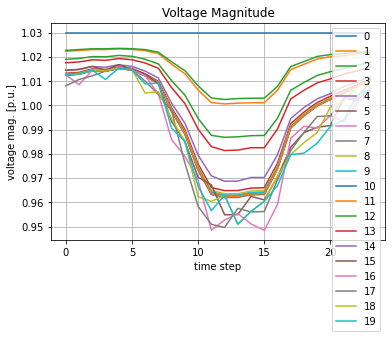

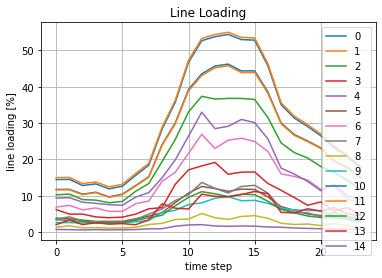

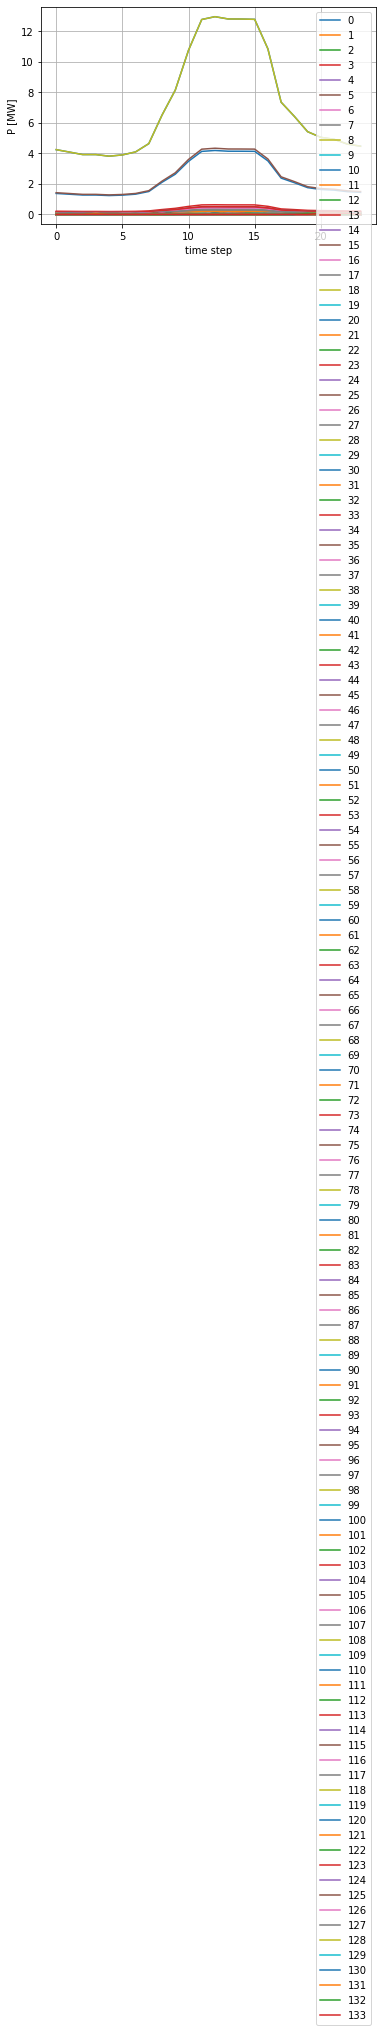

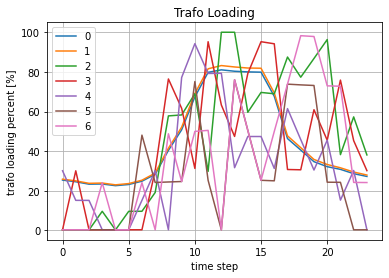

In [277]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

#trafo results
load_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="trafo")
plt.xlabel("time step")
plt.ylabel("trafo loading percent [%]")
plt.title("Trafo Loading")
plt.grid()
plt.show()



In [278]:
c15

45

In [279]:
c16

69

In [280]:
c17

90

In [281]:
c18

103

In [282]:
c19

116

In [283]:
trafo_loading.max()

0    81.020922
1    83.181789
2    99.991247
3    95.216172
4    94.238099
5    76.016095
6    98.246933
dtype: float64